<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-bt9jyqmi
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-bt9jyqmi
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4723 sha256=a3836bc2acd667d1b19963df55bcc38c92372ddb26437f9791c7ddc5d67aebea
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2l5m_3u/wheels/d0/67/1b/569e9d602b147a53e4ab67a3592944572d7d3886dc3a2e095e
Successfully built perlin-numpy


In [4]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56262 sha256=209facdaa42a9ae07ce95aab5f0d37ef79eb4bc7ebfec2cdbbc7840935cd6d43
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
import numpy as np
from perlin_numpy import generate_perlin_noise_2d
import noise
from noise import pnoise2
from noise import snoise3
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense

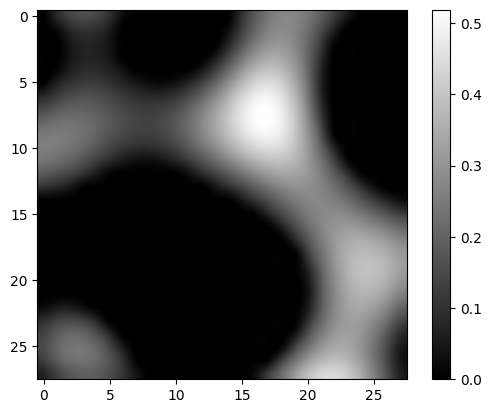

In [7]:
#np.random.seed(1)
noise = generate_perlin_noise_2d((28, 28), (2, 2))
noise = np.clip(noise,0,1)
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

In [8]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)


# Example usage
image_index = 0  # Index of the image you want to retrieve
image = x_train[image_index]
print(image.shape)
print(x_train.shape[0])


11490434/11490434 [==============================] - 0s 0us/step
(28, 28)
60000


In [9]:
print(np.max(x_train))

1.0


In [10]:
x_train2 = x_train[:100]
y_train2 = y_train[:100]

In [13]:
class AddNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev, probability, **kwargs):
        super(AddNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
        self.probability = probability

    def call(self, inputs, training=None):
        if training:

            if tf.random.uniform(()) < self.probability:
                perlin = generate_perlin_noise_2d((28, 28), (2, 2))
                perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
                perlin = tf.clip_by_value(perlin, 0, 1)
                perlin = tf.reshape(perlin, (28, 28, 1))
                noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
                output = inputs + noise * perlin
                return tf.clip_by_value(output, 0, 1)
            else:
                return inputs
        return inputs

In [29]:
class AddNoiseLayertest(tf.keras.layers.Layer):
    def __init__(self, stddev=.5, **kwargs):
        super(AddNoiseLayertest, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:

              perlin = generate_perlin_noise_2d((28, 28), (2, 2))
              perlin = tf.convert_to_tensor(perlin, dtype=tf.float32)
              perlin = tf.clip_by_value(perlin, 0, 1)
              perlin = tf.reshape(perlin, (28, 28, 1))
              noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
              output = inputs + noise * perlin
              return tf.clip_by_value(output, 0, 1)
        return inputs

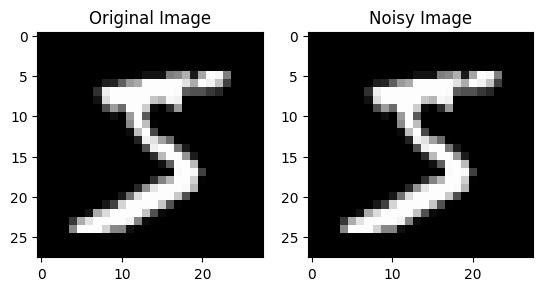

(28, 28, 1)


In [14]:
# Create a random 28x28 image tensor
image = x_train[0]
image = np.expand_dims(image,-1)
# Instantiate the RandomNoiseLayer
GaussianPerlinNoiseLayer = AddNoiseLayer(.5,.5)

# Pass the image through the layer
noisy_image = GaussianPerlinNoiseLayer(image,training=True)

# Display the original and noisy images
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')  # Display the original image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(noisy_image), cmap='gray')  # Display the noisy image
plt.title('Noisy Image')
plt.show()

print(noisy_image.shape)

In [15]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = tf.keras.activations.get(activation)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = tf.keras.layers.add([x, shortcut])
        x = self.activation(x)

        return x

In [27]:
class CustomFullAug(tf.keras.layers.Layer):
    def __init__(self, probability=.2,rot_factor=.2,height=.2,width=.2,stdev=.2):
        super(CustomFullAug, self).__init__()
        self.probability = probability

        self.rot_factor = rot_factor
        self.height = height
        self.width = width
        self.stdev = stdev
        self.flip_layer = tf.keras.layers.RandomFlip()
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=rot_factor)
        self.noise_layer = AddNoiseLayertest()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            #flipped_data = self.flip_layer(inputs, training=training)
            rotated_data = self.rotation_layer(inputs, training=training)
            zoomed_data = self.zoom_layer(rotated_data, training=training)
            noised = self.noise_layer(zoomed_data, training=training)
            return noised
        else:
            return inputs

In [17]:

class CustomFlipLayer(tf.keras.layers.Layer):
    def __init__(self, probability):
        super(CustomFlipLayer, self).__init__()
        self.probability = probability
        self.flip_layer = tf.keras.layers.RandomFlip()

    def call(self, inputs=.2, training=True):
        if tf.random.uniform(()) < self.probability:
            flipped_data = self.flip_layer(inputs, training=training)
            return flipped_data
        else:
            return inputs

In [18]:
class CustomRotationLayer(tf.keras.layers.Layer):
    def __init__(self, probability, factor):
        super(CustomRotationLayer, self).__init__()
        self.probability = probability
        self.factor = factor
        self.rotation_layer = tf.keras.layers.RandomRotation(factor=factor)

    def call(self, inputs, training=True):
        if tf.random.uniform(()) < self.probability:
            rotated_data = self.rotation_layer(inputs, training=training)
            return rotated_data
        else:
            return inputs

In [19]:
class CustomZoomLayer(tf.keras.layers.Layer):
    def __init__(self, probability,height, width):
        super(CustomZoomLayer, self).__init__()
        self.probability = probability
        self.height = height
        self.width = width
        self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=height,width_factor=width)

    def call(self, inputs, training=False):
        if tf.random.uniform(()) < self.probability:
            zoomed_data = self.zoom_layer(inputs, training=training)
            return zoomed_data
        else:
            return inputs

In [20]:


def build_generator():
    noise_shape = (28,28,1)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 28*28)(input_digit)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)


    x = layers.Concatenate()([noise, digit_embedding])


    x = layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, 2, strides=2, padding="same", activation="tanh")(x)


    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x)
    return model

generator = build_generator()
generator.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 784)       7840        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 28, 1)    0           ['embedding[0][0]']              
                                                                                              

In [30]:

def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 28*28)(digit_input)
    digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #noise = AddNoiseLayer(stddev=0.2,probability=.1)(input_image)  # Pass the input image through the PerlinNoiseLayer
    aug = CustomFullAug()(input_image)
    merged_input = layers.Concatenate()([aug, digit_embedding_2d])

    x = layers.Conv2D(64,4,strides=(1,1),padding='same',activation='gelu')(merged_input)
    x = layers.Dropout(.2)(x)
    x = layers.Conv2D(64,4,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Conv2D(64,3,strides=(2,2),padding='same',activation='gelu')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Conv2D(64,2,strides=(2,2),padding='same',activation='tanh')(x)
    x = layers.Dropout(.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 784)       7840        ['input_10[0][0]']               
                                                                                                  
 custom_full_aug_1 (CustomFullA  (None, 28, 28, 1)   0           ['input_9[0][0]']                
 ug)                                                                                        

In [31]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 28, 28, 1)    939233      ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 1)            129953      ['model[1][0]',            

In [32]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



Epoch 5/20000
1/1 [==============================] - 0s 85ms/step


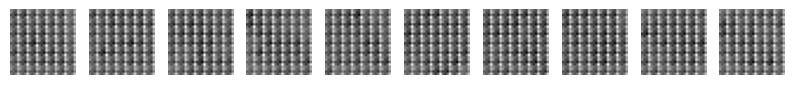

Epoch 10/20000
1/1 [==============================] - 0s 80ms/step


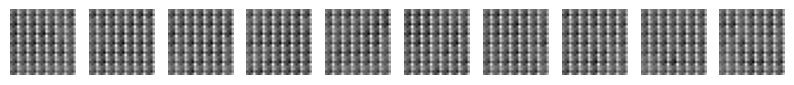

Epoch 15/20000
1/1 [==============================] - 0s 84ms/step


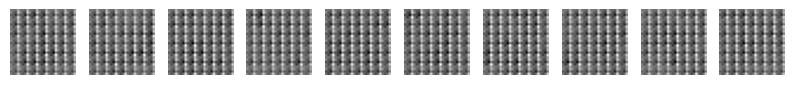

Epoch 20/20000
1/1 [==============================] - 0s 76ms/step


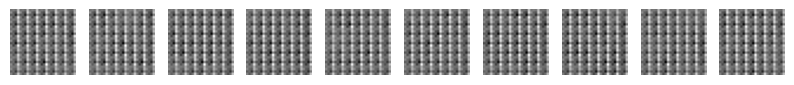

Epoch 25/20000
1/1 [==============================] - 0s 87ms/step


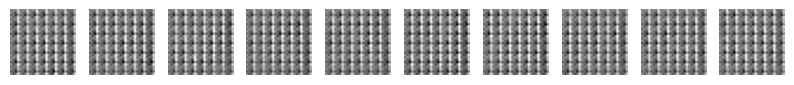

Epoch 30/20000
1/1 [==============================] - 0s 84ms/step


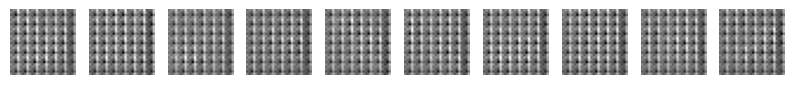

Epoch 35/20000
1/1 [==============================] - 0s 76ms/step


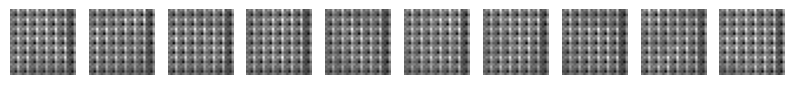

Epoch 40/20000
1/1 [==============================] - 0s 77ms/step


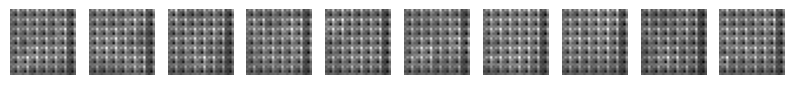

Epoch 45/20000
1/1 [==============================] - 0s 73ms/step


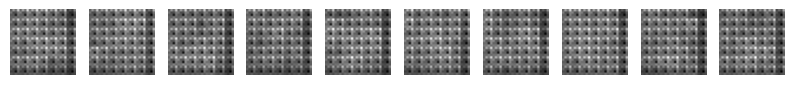

Epoch 50/20000
1/1 [==============================] - 0s 82ms/step


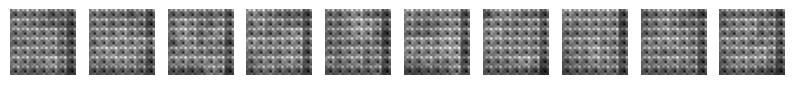

Epoch 55/20000
1/1 [==============================] - 0s 79ms/step


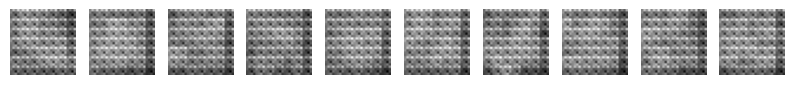

Epoch 60/20000
1/1 [==============================] - 0s 80ms/step


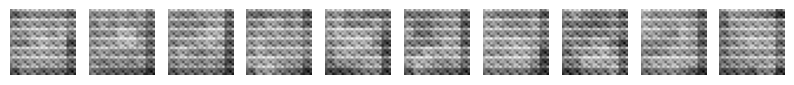

Epoch 65/20000
1/1 [==============================] - 0s 78ms/step


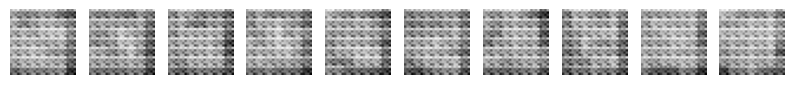

Epoch 70/20000
1/1 [==============================] - 0s 77ms/step


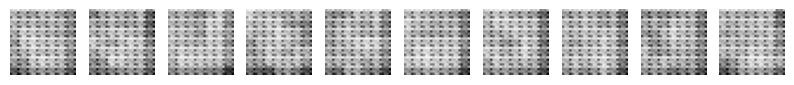

KeyboardInterrupt: ignored

In [34]:


@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28,28,1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(generator, discriminator, gan, epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(x_train2) // batch_size):
            images = x_train2[batch * batch_size: (batch+1) * batch_size]
            labels = y_train2[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28,28,1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = generated_images#(generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE)